# <font  color = "#0093AF"> TROSY effects

TROSY (Transverse Relaxation Optimized SPectroscopy)$^1$ is an important experiment in solution-NMR, which takes advantage of different relaxation rates of doublets in the $^1$H or $^{15}$N dimensions, due to the H–N J coupling. 

The effect arises from the constructive or deconstructive effects of motion on relaxation due to the $^{15}$N chemical shift anisotropy (or $^1$H CSA) and the H–N dipole coupling. For one side of the doublet, relaxation is additive from the CSA and dipole, but on the other side it is subtractive, resulting in one fast-relaxing peak and one slow-relaxing peak.

Here, we will assume these two interactions are parallel. This is not entirely accurate (being tilted from each other by about 23$^\circ$, but it allows us to average the couplings to zero with a simple, tetrahedral hopping motion.

[1] K. Pervushin, R. Riek, G. Wider, K. Wüthrich. *[Proc. Natl. Acad. Sci. USA.](https://doi.org/10.1073/pnas.94.23.12366)* **1997**, 94, 12366 

## Setup

In [1]:
# SETUP SLEEPY
import os
os.chdir('../../../')

In [2]:
import SLEEPY as sl
import numpy as np
import matplotlib.pyplot as plt

## Build the system

In [6]:
ex=sl.ExpSys(v0H=400,Nucs=['15N','1H'],vr=0)
delta=sl.Tools.dipole_coupling(.102,'1H','15N')
ex.set_inter('dipole',i0=0,i1=1,delta=delta)
ex.set_inter('CSA',i=0,delta=113)
ex.set_inter('J',i0=0,i1=1,J=92)

# Set up 4-site motion
ex,kex=sl.Tools.SetupTumbling(ex,tc=1e-9,q=1) #Defaults to the magic angle, which will average the couplings

L=sl.Liouvillian(*ex,kex=kex)

## 1D spectrum

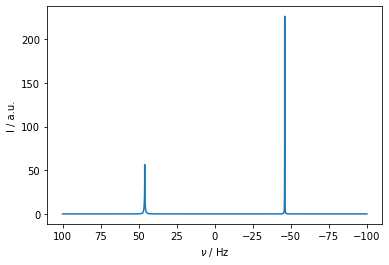

In [8]:
rho=sl.Rho('15Nx','15Np')
seq=L.Sequence(Dt=5e-3)

rho.DetProp(seq,n=10000)
_=rho.plot(FT=True)

We obtain two peaks, separated by the J-coupling, one being notably larger than the other, where relaxation effects from the $^{15}$N CSA and H–N dipole coupling cancel. Note that since the CSA scales with field, the cancelation effect is also field dependent. We calculate the spectrum maximum as a function of field to demonstrate.

Text(0, 0.5, 'Spectrum Max [a.u.]')

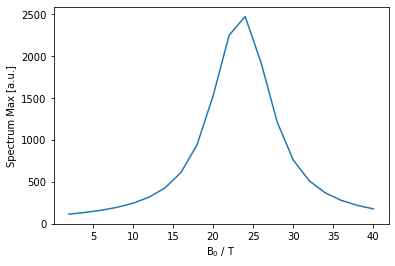

In [9]:
sl.Defaults['verbose']=False #Suppress output for loop
B0_0=np.linspace(2,40,20)
I=[]
for B0 in B0_0:
    ex=sl.ExpSys(B0=B0,Nucs=['15N','1H'],vr=0)
    ex.set_inter('dipole',i0=0,i1=1,delta=delta)
    ex.set_inter('CSA',i=0,delta=113)
    ex.set_inter('J',i0=0,i1=1,J=92)
    
    ex,kex=sl.Tools.SetupTumbling(ex,tc=1e-9,q=1) #Defaults to the magic angle, which will average the couplings

    L=sl.Liouvillian(*ex,kex=kex)
    rho=sl.Rho('15Nx','15Np')
    seq=L.Sequence(Dt=5e-3)

    rho.DetProp(seq,n=10000)
    I.append(rho.FT[0].real.max())
ax=plt.subplots()[1]
ax.plot(B0_0,I)
ax.set_xlabel(r'B$_0$ / T')
ax.set_ylabel('Spectrum Max [a.u.]')

We see the max occuring at ~24 T, as predicted by Fernández and Wider (23.5 T).$^1$

[1] C. Fernández, G. Wider. *[Curr. Opin. Struct. Biol.](https://doi.org/10.1016/j.sbi.2003.09.009)*. **2003**, 13, 570-580.

## With and without decoupling
We can also compare what happens to the spectrum without and with decoupling. We go a little ways away from the optimal field so we can actually see all peaks.

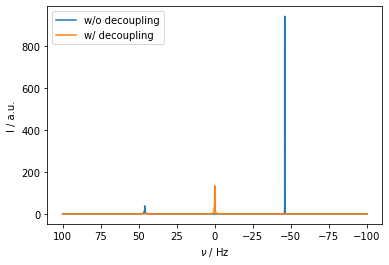

In [10]:
ex=sl.ExpSys(B0=18,Nucs=['15N','1H'],vr=0)
delta=sl.Tools.dipole_coupling(.102,'1H','15N')
ex.set_inter('dipole',i0=0,i1=1,delta=delta)
ex.set_inter('CSA',i=0,delta=113)
ex.set_inter('J',i0=0,i1=1,J=92)

# Set up 4-site motion
ex,kex=sl.Tools.SetupTumbling(ex,tc=1e-9,q=1) #Defaults to the magic angle, which will average the couplings

L=sl.Liouvillian(*ex,kex=kex)

rho=sl.Rho('15Nx','15Np')
seq=L.Sequence(Dt=5e-3)

rho.DetProp(seq,n=10000)
ax=rho.plot(FT=True)

seq.add_channel('1H',v1=500)

rho.clear()
rho.DetProp(seq,n=10000)
rho.plot(FT=True,ax=ax)
_=ax.legend(('w/o decoupling','w/ decoupling'))

The decoupled spectrum has significantly less intensity than the undecoupled spectrum, motivating the application of TROSY. Note that the integrals should be the same.

## Longitudinal effects from asymmetric relaxation

When measuring $T_1$ in solution NMR, one must take care to account for multiexponential $T_1$ relaxation. To obtain $T_1$ relaxation from exchange, we need to perform our calculations in the lab frame, so we set up a new ExpSys

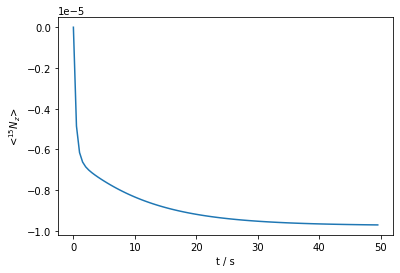

In [3]:
ex0=sl.ExpSys(v0H=1200,Nucs=['15N','1H'],vr=0,LF=True)
delta=sl.Tools.dipole_coupling(.102,'1H','15N')
ex0.set_inter('dipole',i0=0,i1=1,delta=delta)
ex0.set_inter('CSA',i=0,delta=113)
ex0.set_inter('J',i0=0,i1=1,J=92)

# Set up 4-site motion
ex,kex=sl.Tools.SetupTumbling(ex0,tc=1e-9,q=1) #Defaults to the magic angle, which will average the couplings

L=sl.Liouvillian(*ex,kex=kex)
L.add_relax('DynamicThermal')

rho=sl.Rho('zero','15Nz')
seq=L.Sequence(Dt=.5)

rho.DetProp(seq,n=100)
_=rho.plot(axis='s')

We observe a strongly bi-exponential behavior, corresponding to relaxation of the $\hat{S}_z\hat{I}_\alpha$ and $\hat{S}_z\hat{I}_\beta$ states. We can saturate the $^1$H to recovery monoexponential behavior. However, because this calculation is in the lab frame, we cannot irradiate based on the usual approach. This is because the applied RF is not static in the lab frame, but rather oscillates as in the real experiment, complicating its application in simulation. SLEEPY has a special tool for adding cw-irradation in the lab frame

LF calculation: |██████████████████████████████| 100% complete
Completed


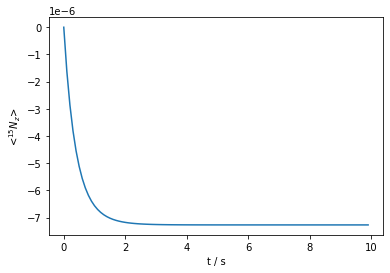

In [3]:
rho.clear()
seq=L.Sequence(Dt=.1).add_channel('1H',v1=500)
U=sl.LFrf(seq).U()
rho.DetProp(U,n=100)
_=rho.plot(axis='s')

The decay curve becomes monoexponential. Note the equilibrium value's absolute value is also slightly decreased, due to an unfavorable NOE condition at 1 ns for H–N NOE.

Here, we should make a note of limitation of SLEEPY. If we initialize the system with "Thermal" while using "DynamicThermal" relaxation, the system should not evolve unless we apply pulses, since the system is already at thermal equilibrium. For example, see the code below:

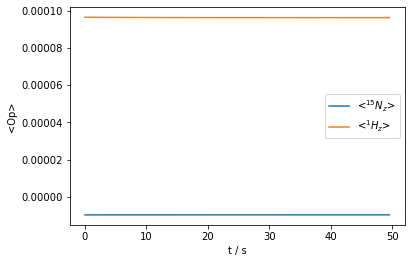

In [4]:
L.kex=sl.Tools.nSite_sym(n=4,tc=1e-9) #Defaults to the magic angle, which will average the couplings
L.add_relax('DynamicThermal') #Dynamic thermal needs updated after adjusting kex

rho=sl.Rho('Thermal',['15Nz','1Hz'])
seq=L.Sequence(Dt=.5)

rho.DetProp(seq,n=100)
_=rho.plot(axis='s')

However, if we adjust the correlation time to correspond to a faster motion, we find this is no longer the case.

/Users/albertsmith/Documents/GitHub/SLEEPY/Rho.py:1264: UserWarning: Evolution time is more than 12 orders of magnitude different than largest Liouvillian term:
Numerical error possible
  warnings.warn('Evolution time is more than 12 orders of magnitude different than largest Liouvillian term:\nNumerical error possible')
/Users/albertsmith/Documents/GitHub/SLEEPY/Rho.py:1264: UserWarning: Evolution time is more than 12 orders of magnitude different than largest Liouvillian term:
Numerical error possible
  warnings.warn('Evolution time is more than 12 orders of magnitude different than largest Liouvillian term:\nNumerical error possible')


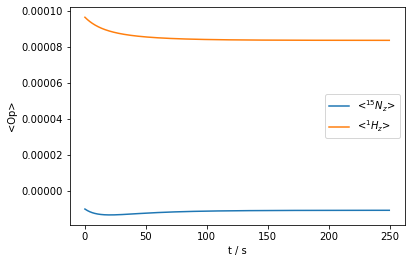

In [5]:
L.kex=sl.Tools.nSite_sym(n=4,tc=1e-11) #Defaults to the magic angle, which will average the couplings
L.add_relax('DynamicThermal')

rho=sl.Rho('Thermal',['15Nz','1Hz'])
seq=L.Sequence(Dt=.5)

rho.DetProp(seq,n=500)
_=rho.plot(axis='s')

Now, we observe some slow evolution away from the starting values. The issue is that we have some terms as large as 1x10$^{11}$ s$^{-1}$, but evolution is occuring on a time scale about 12 orders of magnitude slower. So, this is numerical error, brought about by large differences in order-of-magnitude. This error should be fairly exceptional; we provide a warning when the total evolution time and the largest term in the Hamiltonian have a product of more than 10$^{12}$.
